https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb
https://www.youtube.com/watch?v=8N-nM3QW7O0

In [ ]:
import pandas as pd 
import numpy as np
import sklearn
import tensorflow
import torch

In [ ]:
!pip install -q -U watermark

In [ ]:
#!pip install -qq transformers

In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 18.1MB/s 
     |████████████████████████████████| 3.0MB 54.7MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
     |████████████████████████████████| 1.2MB 52.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=071fc7db5f3fe08887360ba82d0019652cc1f283d68cf2c50e16edd1127f4ab3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 3.0.0



In [ ]:
#@title Setup & Config { display-mode: "code" }
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
# Special Tokens
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/IR_Project/Labelled_Dataset_Arpit/2020-09-13_2020-09-19.csv")
df = pd.read_csv("/content/drive/MyDrive/IR_Project/Final_22_MAR-DATASET/Working_copy_22_MAR_Ver2.csv")

In [ ]:
df

,Unnamed: 0,Datetime,Tweet Id,Text,Username,FollowersCount,likeCount,retweetCount,quoteCount,Label
0,2.0,2020-12-01 20:27:34+00:00,1.330000e+18,This actually broke my heart... An elderly Kis...,HayreSay,1408,120,24,12,PRO_FARMER
1,5.0,2020-12-01 19:46:56+00:00,1.330000e+18,"I am a daughter of farmers, of course Iâ€™m go...",humneet06,646,120,39,8,PRO_FARMER
2,8.0,2020-12-01 19:04:34+00:00,1.330000e+18,â€œthe power of people is stronger than the pe...,mansikaur_,1700,219,63,20,PRO_FARMER
3,9.0,2020-12-01 19:04:24+00:00,1.330000e+18,Coming together is the beginning. Keeping toge...,khalramission,4103,169,31,18,PRO_FARMER
4,10.0,2020-12-01 18:50:42+00:00,1.330000e+18,The farmers are more articulate and aware than...,parthpunter,15535,254,41,4,PRO_FARMER
...,...,...,...,...,...,...,...,...,...,...
1243,NaN,2020-11-27 08:58:32+00:00,1.330000e+18,AAP MLA @JarnailSinghAAP arrested for protesti...,VickyKedia,6532,209,83,0,NEUTRAL
1244,NaN,2020-11-27 08:56:11+00:00,1.330000e+18,This is a brutal and merciless attack by Modi ...,sunmor2901,3977,211,142,8,ANTI_GOVT
1245,NaN,2020-11-27 08:55:00+00:00,1.330000e+18,From the barbed wires\n From the showers of wa...,SurrbhiM,5717,234,137,5,PRO_FARMER
1246,NaN,2020-11-27 08:53:44+00:00,1.330000e+18,Orders from above - use 'misguised' for #Farme...,TheDeshBhakt,501907,503,66,2,PRO_FARMER


In [ ]:
class_names = ['PRO_GOVT', 'ANTI_FARMER', 'NEUTRAL', 'PROVOKING', 'PRO_FARMER', 'ANTI_GOVT']

dict_class = {'PG':0, 'AF':1, 'N':2, 'P':3, 'PF':4, 'AG':5}

df['numeric_Label'] = df.Label

for i in range(len(class_names)):
    df.numeric_Label[df['numeric_Label'] == class_names[i]] = i

df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,Datetime,Tweet Id,Text,Username,FollowersCount,likeCount,retweetCount,quoteCount,Label,numeric_Label
0,2.0,2020-12-01 20:27:34+00:00,1.330000e+18,This actually broke my heart... An elderly Kis...,HayreSay,1408,120,24,12,PRO_FARMER,4
1,5.0,2020-12-01 19:46:56+00:00,1.330000e+18,"I am a daughter of farmers, of course Iâ€™m go...",humneet06,646,120,39,8,PRO_FARMER,4
2,8.0,2020-12-01 19:04:34+00:00,1.330000e+18,â€œthe power of people is stronger than the pe...,mansikaur_,1700,219,63,20,PRO_FARMER,4
3,9.0,2020-12-01 19:04:24+00:00,1.330000e+18,Coming together is the beginning. Keeping toge...,khalramission,4103,169,31,18,PRO_FARMER,4
4,10.0,2020-12-01 18:50:42+00:00,1.330000e+18,The farmers are more articulate and aware than...,parthpunter,15535,254,41,4,PRO_FARMER,4
...,...,...,...,...,...,...,...,...,...,...,...
1243,NaN,2020-11-27 08:58:32+00:00,1.330000e+18,AAP MLA @JarnailSinghAAP arrested for protesti...,VickyKedia,6532,209,83,0,NEUTRAL,2
1244,NaN,2020-11-27 08:56:11+00:00,1.330000e+18,This is a brutal and merciless attack by Modi ...,sunmor2901,3977,211,142,8,ANTI_GOVT,5
1245,NaN,2020-11-27 08:55:00+00:00,1.330000e+18,From the barbed wires\n From the showers of wa...,SurrbhiM,5717,234,137,5,PRO_FARMER,4
1246,NaN,2020-11-27 08:53:44+00:00,1.330000e+18,Orders from above - use 'misguised' for #Farme...,TheDeshBhakt,501907,503,66,2,PRO_FARMER,4


In [ ]:
token_lens = []

for txt in df.Text:
  tokens = tokenizer.encode(txt, max_length=280)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was n

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


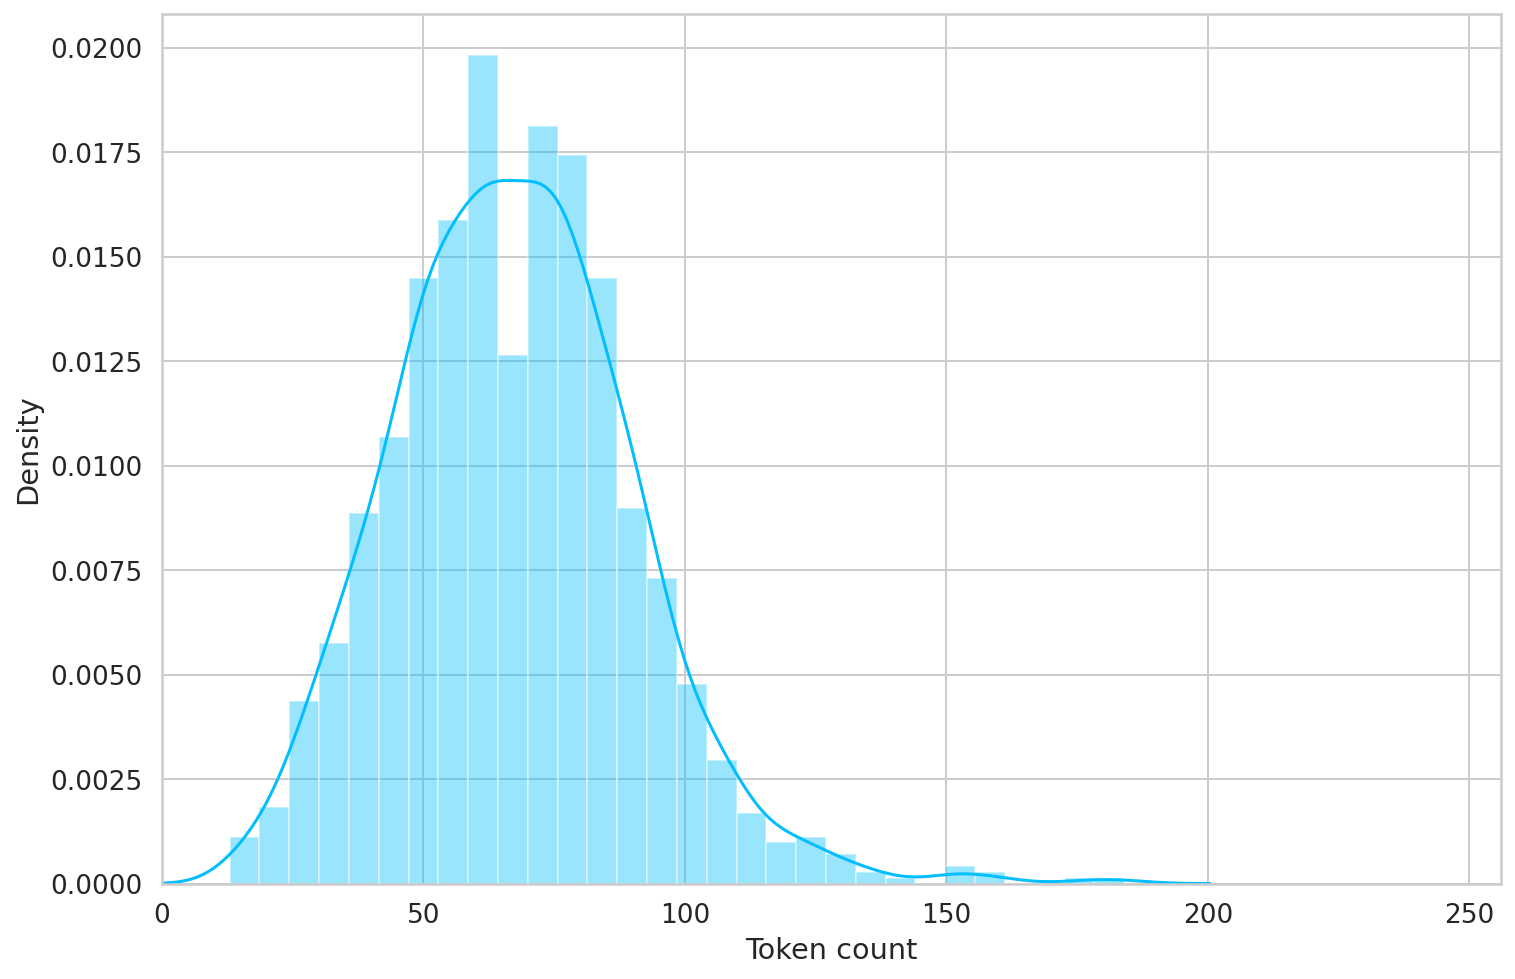

In [ ]:

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:

MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
short_df = df[["Text", "numeric_Label"]]
short_df.columns = ['DATA', 'LABEL']
short_df.head()

,DATA,LABEL
0,This actually broke my heart... An elderly Kis...,4
1,"I am a daughter of farmers, of course Iâ€™m go...",4
2,â€œthe power of people is stronger than the pe...,4
3,Coming together is the beginning. Keeping toge...,4
4,The farmers are more articulate and aware than...,4


In [ ]:
df_train, df_test = train_test_split(short_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1123, 2), (62, 2), (63, 2))

In [ ]:
df.info(), short_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      460 non-null    float64
 1   Datetime        1248 non-null   object 
 2   Tweet Id        1248 non-null   float64
 3   Text            1248 non-null   object 
 4   Username        1248 non-null   object 
 5   FollowersCount  1248 non-null   int64  
 6   likeCount       1248 non-null   int64  
 7   retweetCount    1248 non-null   int64  
 8   quoteCount      1248 non-null   int64  
 9   Label           1248 non-null   object 
 10  numeric_Label   1248 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 107.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATA    1248 non-null   object
 1   LABEL   1248 non-null   o

(None, None)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=short_df.DATA.to_numpy(),
    targets=short_df.LABEL.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:

last_hidden_state

tensor([[[ 0.4070,  0.1858, -0.2489,  ..., -0.0298,  0.1574, -0.0787],
         [ 0.2521, -0.4902,  0.4746,  ..., -0.3883,  0.2401, -0.1347],
         [ 0.0866, -0.0274, -0.5215,  ...,  0.6011, -0.2430,  0.6801],
         ...,
         [ 0.0442, -0.0196,  0.2204,  ...,  0.1434,  0.1860, -0.0502],
         [ 0.2445, -0.1682,  0.0136,  ...,  0.1560,  0.5221,  0.0610],
         [ 0.1657, -0.0233,  0.1242,  ...,  0.1789,  0.2596,  0.0111]]],
       grad_fn=<NativeLayerNormBackward>)

In [ ]:
bert_model.config.hidden_size

768

In [ ]:

pooled_output

tensor([[-7.1750e-01,  4.5661e-01,  9.9983e-01, -9.9218e-01,  9.6206e-01,
          9.2055e-01,  9.8129e-01, -9.8628e-01, -9.5908e-01, -6.2142e-01,
          9.7354e-01,  9.9778e-01, -9.9626e-01, -9.9973e-01,  6.3165e-01,
         -9.7639e-01,  9.8318e-01, -5.3571e-01, -9.9994e-01, -6.7816e-01,
         -1.9957e-01, -9.9982e-01,  2.8625e-01,  9.6940e-01,  9.6161e-01,
          7.7488e-02,  9.7733e-01,  9.9994e-01,  8.0861e-01, -9.9909e-02,
          3.0196e-01, -9.8676e-01,  8.5750e-01, -9.9825e-01,  1.6589e-01,
          2.6509e-01,  6.9193e-01, -2.4500e-01,  9.2214e-01, -9.3336e-01,
         -5.3641e-01, -7.4646e-01,  6.8753e-01, -5.3900e-01,  8.5151e-01,
          9.6114e-02,  2.1984e-01, -1.5041e-01, -1.8023e-01,  9.9985e-01,
         -9.5577e-01,  9.9827e-01, -9.9100e-01,  9.9434e-01,  9.9250e-01,
          2.6691e-01,  9.9225e-01,  1.7253e-01, -9.9740e-01,  2.5879e-01,
          9.3056e-01,  2.1229e-01,  8.6981e-01, -1.5434e-01,  1.0194e-02,
         -1.2379e-01, -9.1026e-01,  2.

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2620, 0.1210, 0.2518, 0.1417, 0.1688, 0.0547],
        [0.2614, 0.0853, 0.1866, 0.1602, 0.2035, 0.1030],
        [0.1835, 0.0980, 0.3478, 0.1001, 0.1965, 0.0742],
        [0.3294, 0.0987, 0.2351, 0.1304, 0.1499, 0.0564],
        [0.3255, 0.1119, 0.1279, 0.0922, 0.2651, 0.0773],
        [0.2016, 0.1026, 0.3047, 0.1098, 0.2088, 0.0725],
        [0.2173, 0.0815, 0.2391, 0.0836, 0.2993, 0.0793],
        [0.1710, 0.1461, 0.2562, 0.1562, 0.1981, 0.0724],
        [0.2196, 0.1068, 0.3483, 0.0972, 0.1530, 0.0751],
        [0.1280, 0.1173, 0.2745, 0.1358, 0.3047, 0.0397],
        [0.2208, 0.0844, 0.2324, 0.1292, 0.2652, 0.0680],
        [0.2553, 0.1436, 0.2302, 0.0979, 0.2350, 0.0379],
        [0.3037, 0.0537, 0.1901, 0.1950, 0.1908, 0.0667],
        [0.2438, 0.0826, 0.2028, 0.1335, 0.2225, 0.1147],
        [0.2429, 0.1011, 0.2441, 0.1712, 0.1756, 0.0650],
        [0.2050, 0.1047, 0.2601, 0.1173, 0.2363, 0.0766]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:

EPOCHS = 10


optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import warnings
warnings.filterwarnings("ignore")


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
#FOR 10 EPOCHS
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.615551193555196 accuracy 0.3757791629563669
Val   loss 1.580569360500727 accuracy 6.661290322580645

Epoch 2/10
----------
Train loss 1.527145539338772 accuracy 0.4603739982190561
Val   loss 1.3282357194484808 accuracy 10.403225806451612

Epoch 3/10
----------
Train loss 1.3493385421924102 accuracy 0.5868210151380231
Val   loss 1.0452465751232245 accuracy 13.403225806451612

Epoch 4/10
----------
Train loss 1.0513984262943268 accuracy 0.7284060552092609
Val   loss 0.7283390313386917 accuracy 15.580645161290322

Epoch 5/10
----------
Train loss 0.7327479366690685 accuracy 0.8495102404274265
Val   loss 0.47021360876850593 accuracy 17.370967741935484

Epoch 6/10
----------
Train loss 0.5370466581139809 accuracy 0.9136242208370436
Val   loss 0.36112456802183235 accuracy 18.112903225806452

Epoch 7/10
----------
Train loss 0.39286458836152005 accuracy 0.9741763134461264
Val   loss 0.27598334013078457 accuracy 18.532258064516128

Epoch 8/10
----------
Train

In [ ]:
#FOR 30 EPOCHS

%%time
EPOCHS = 30

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/30
----------
Train loss 0.6165222764039078 accuracy 0.8967052537845057
Val   loss 0.3248787737475374 accuracy 17.967741935483872

Epoch 2/30
----------
Train loss 0.4795690779693616 accuracy 0.9483526268922529
Val   loss 0.2653263221817234 accuracy 18.629032258064516

Epoch 3/30
----------
Train loss 0.3061314686977615 accuracy 1.0044523597506678
Val   loss 0.21798272853275427 accuracy 18.838709677419356

Epoch 4/30
----------
Train loss 0.21780394749620405 accuracy 1.043633125556545
Val   loss 0.11465265791719922 accuracy 19.564516129032256

Epoch 5/30
----------
Train loss 0.1256025654192154 accuracy 1.0712377560106856
Val   loss 0.04618122122244527 accuracy 19.870967741935484

Epoch 6/30
----------
Train loss 0.05146688558101559 accuracy 1.0979519145146928
Val   loss 0.02390758056814472 accuracy 19.967741935483872

Epoch 7/30
----------
Train loss 0.03124280650286565 accuracy 1.1050756901157612
Val   loss 0.014838062924517987 accuracy 20.048387096774192

Epoch 8/30
--------

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()